In [1]:
# Basic packages
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import math
import netCDF4 as nc

# DateTime packages
from matplotlib.dates import DateFormatter
from datetime import datetime, timedelta
import time
import matplotlib.dates as mdates

# Stats packages
import scipy
import bottleneck as bn
import PyCO2SYS as pyco2
import gsw
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import seaborn as sns

# Logistical packages
import requests
from importlib import reload
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText

# ROMS OSOM/CoSiNE Model Domain

In [2]:
grid = xr.open_mfdataset('/Users/akbaskind/Desktop/Dissertation/osom_grid5_mod4.nc')
grid

<xarray.Dataset>
Dimensions:    (eta_rho: 550, xi_rho: 500, bath: 0, eta_psi: 549, xi_psi: 499, eta_u: 550, xi_u: 499, eta_v: 549, xi_v: 500)
Dimensions without coordinates: eta_rho, xi_rho, bath, eta_psi, xi_psi, eta_u, xi_u, eta_v, xi_v
Data variables: (12/31)
    spherical  int32 ...
    xl         float64 ...
    el         float64 ...
    angle      (eta_rho, xi_rho) float64 dask.array<chunksize=(550, 500), meta=np.ndarray>
    pm         (eta_rho, xi_rho) float64 dask.array<chunksize=(550, 500), meta=np.ndarray>
    pn         (eta_rho, xi_rho) float64 dask.array<chunksize=(550, 500), meta=np.ndarray>
    ...         ...
    lon_v      (eta_v, xi_v) float64 dask.array<chunksize=(549, 500), meta=np.ndarray>
    lat_v      (eta_v, xi_v) float64 dask.array<chunksize=(549, 500), meta=np.ndarray>
    mask_rho   (eta_rho, xi_rho) float64 dask.array<chunksize=(550, 500), meta=np.ndarray>
    mask_psi   (eta_psi, xi_psi) float64 dask.array<chunksize=(549, 499), meta=np.ndarray>
    mask_u     (eta_u, xi_u) float64 dask.array<chunksize=(550, 499), meta=np.ndarray>
    mask_v     (eta_v, xi_v) float64 dask.array<chunksize=(549, 500), meta=np.ndarray>
Attributes:
    type:     GRID file
    history:  GRID file half size of osom_grid4_mindep_smlp_mod9.nc, created ...

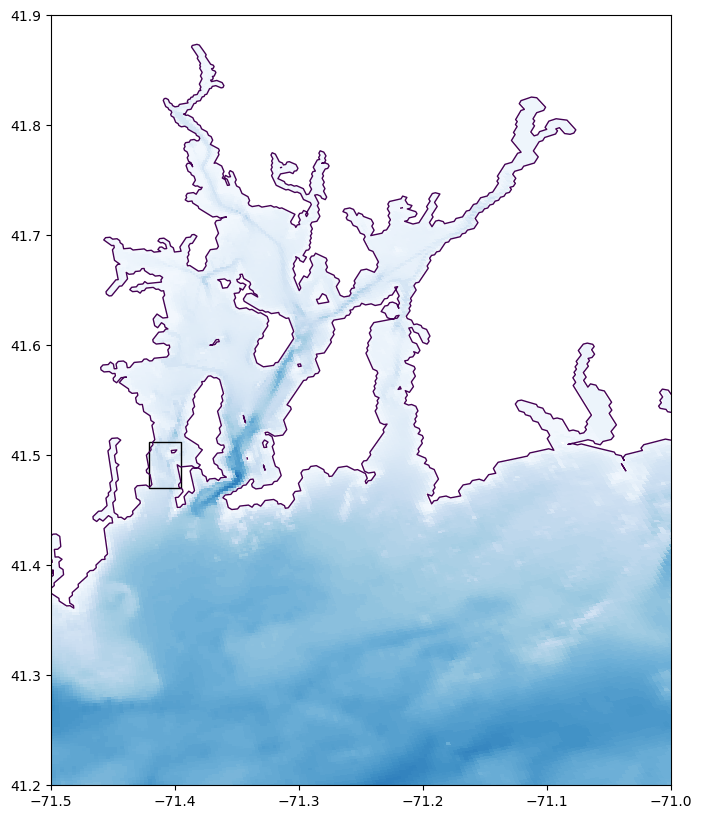

In [48]:
fig, ax = plt.subplots(figsize = [8,10])
from matplotlib.patches import Polygon

ax.contour(grid['lon_rho'], grid['lat_rho'], grid['mask_rho'], c = 'k', linewidths = 1, levels = [0])
im = ax.pcolormesh(grid['lon_rho'], grid['lat_rho'], grid['h'].where(grid['mask_rho'] > 0), cmap = 'Blues', vmin = 0, vmax = 70)
ax.plot(grid['lon_rho'].isel(eta_rho = 0), grid['lat_rho'].isel(eta_rho = 0), c = 'r', lw = 3)
ax.set_xlim([-71.5,-71])
ax.set_ylim([41.2,41.9])

x1 = -71.42093
y1 = 41.4699
y2 = 41.512324
x2 = -71.395244

y = np.array([[x1,y1], [x1,y2], [x2,y2], [x2,y1]])

p = Polygon(y, facecolor = 'none', edgecolor = 'k')

ax.add_patch(p)

In [74]:
eta_lo = grid['eta_rho'].where((grid['lon_rho'] >= -71.42093) & (grid['lon_rho'] <= -71.395244)).where((grid['lat_rho'] >= 41.4699) & (grid['lat_rho'] <= 41.512324)).min().values
eta_hi = grid['eta_rho'].where((grid['lon_rho'] >= -71.42093) & (grid['lon_rho'] <= -71.395244)).where((grid['lat_rho'] >= 41.4699) & (grid['lat_rho'] <= 41.512324)).max().values
xi_lo = grid['xi_rho'].where((grid['lon_rho'] >= -71.42093) & (grid['lon_rho'] <= -71.395244)).where((grid['lat_rho'] >= 41.4699) & (grid['lat_rho'] <= 41.512324)).min().values
xi_hi = grid['xi_rho'].where((grid['lon_rho'] >= -71.42093) & (grid['lon_rho'] <= -71.395244)).where((grid['lat_rho'] >= 41.4699) & (grid['lat_rho'] <= 41.512324)).max().values


In [131]:
temp = {'Eta Coord': [], 'Xi Coord': [], 'Lat': [], 'Lon': [], 'X': [], 'Y': [], 'Z': []}

# SW Corner
temp['Eta Coord'].append(eta_lo)
temp['Xi Coord'].append(xi_lo)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values)
temp['Z'].append(grid['h'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values)

# NW Corner
temp['Eta Coord'].append(eta_hi)
temp['Xi Coord'].append(xi_lo)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_lo)).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_lo)).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_lo)).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_lo)).values)
temp['Z'].append(grid['h'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_lo)).values)

# NE Corner
temp['Eta Coord'].append(eta_hi)
temp['Xi Coord'].append(xi_hi)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_hi)).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_hi)).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_hi)).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_hi)).values)
temp['Z'].append(grid['h'].sel(eta_rho = int(eta_hi), xi_rho = int(xi_hi)).values)

# SE Corner
temp['Eta Coord'].append(eta_lo)
temp['Xi Coord'].append(xi_hi)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_hi)).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_hi)).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_hi)).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_hi)).values)
temp['Z'].append(grid['h'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_hi)).values)

# Point 1
ETA = 317
XI = 240
temp['Eta Coord'].append(ETA)
temp['Xi Coord'].append(XI)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Z'].append(grid['h'].sel(eta_rho = ETA, xi_rho = XI).values)

# Point 2
ETA = 312
XI = 245
temp['Eta Coord'].append(ETA)
temp['Xi Coord'].append(XI)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Z'].append(grid['h'].sel(eta_rho = ETA, xi_rho = XI).values)

# Point 3
ETA = 303
XI = 241
temp['Eta Coord'].append(ETA)
temp['Xi Coord'].append(XI)
temp['Lat'].append(grid['lat_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Lon'].append(grid['lon_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['X'].append(grid['x_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Y'].append(grid['y_rho'].sel(eta_rho = ETA, xi_rho = XI).values)
temp['Z'].append(grid['h'].sel(eta_rho = ETA, xi_rho = XI).values)

df = pd.DataFrame(temp)
df

,Eta Coord,Xi Coord,Lat,Lon,X,Y,Z
0,300.0,235.0,41.468681019756296,-71.41999952000835,-7944771.3908519065,5089612.350542658,6.591229978410642
1,319.0,235.0,41.51086104846511,-71.42693941189647,-7945398.941021484,5095138.367587282,2.0
2,319.0,248.0,41.51387690745878,-71.39777590119103,-7940838.003321426,5095760.135666333,14.365187289546121
3,300.0,248.0,41.47182948424772,-71.3895434167916,-7940008.313592033,5090260.973996682,2.0
4,317,240,41.50758960066907,-71.41488030011506,-7943570.161798857,5094794.557423452,14.776092644529042
5,312,245,41.49776112393453,-71.40155565156131,-7941605.173961596,5093610.619596938,9.769414159209505
6,303,241,41.47680305390335,-71.407071772709,-7942687.16324725,5090784.643041112,13.006438901836873


In [133]:
df['X0'] = df['X'] - grid['x_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values
df['Y0'] = df['Y'] - grid['y_rho'].sel(eta_rho = int(eta_lo), xi_rho = int(xi_lo)).values
df

,Eta Coord,Xi Coord,Lat,Lon,X,Y,Z,X0,Y0
0,300.0,235.0,41.468681019756296,-71.41999952000835,-7944771.3908519065,5089612.350542658,6.591229978410642,0.0,0.0
1,319.0,235.0,41.51086104846511,-71.42693941189647,-7945398.941021484,5095138.367587282,2.0,-627.55017,5526.017045
2,319.0,248.0,41.51387690745878,-71.39777590119103,-7940838.003321426,5095760.135666333,14.365187289546121,3933.38753,6147.785124
3,300.0,248.0,41.47182948424772,-71.3895434167916,-7940008.313592033,5090260.973996682,2.0,4763.07726,648.623454
4,317,240,41.50758960066907,-71.41488030011506,-7943570.161798857,5094794.557423452,14.776092644529042,1201.229053,5182.206881
5,312,245,41.49776112393453,-71.40155565156131,-7941605.173961596,5093610.619596938,9.769414159209505,3166.21689,3998.269054
6,303,241,41.47680305390335,-71.407071772709,-7942687.16324725,5090784.643041112,13.006438901836873,2084.227605,1172.292498


Because the grid is curved, the box isn't perfect so I am dropping the points that occur over land.

In [134]:
df = df[df['Z'] > 2].reset_index()
df

,index,Eta Coord,Xi Coord,Lat,Lon,X,Y,Z,X0,Y0
0,0,300.0,235.0,41.468681019756296,-71.41999952000835,-7944771.3908519065,5089612.350542658,6.591229978410642,0.0,0.0
1,2,319.0,248.0,41.51387690745878,-71.39777590119103,-7940838.003321426,5095760.135666333,14.365187289546121,3933.38753,6147.785124
2,4,317,240,41.50758960066907,-71.41488030011506,-7943570.161798857,5094794.557423452,14.776092644529042,1201.229053,5182.206881
3,5,312,245,41.49776112393453,-71.40155565156131,-7941605.173961596,5093610.619596938,9.769414159209505,3166.21689,3998.269054
4,6,303,241,41.47680305390335,-71.407071772709,-7942687.16324725,5090784.643041112,13.006438901836873,2084.227605,1172.292498


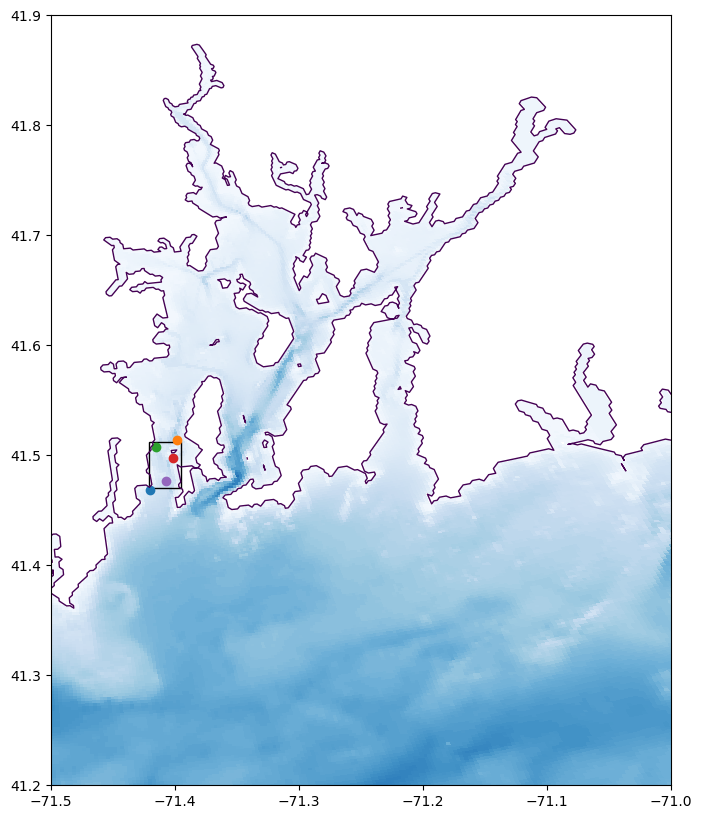

In [135]:
fig, ax = plt.subplots(figsize = [8,10])
from matplotlib.patches import Polygon

ax.contour(grid['lon_rho'], grid['lat_rho'], grid['mask_rho'], c = 'k', linewidths = 1, levels = [0])
im = ax.pcolormesh(grid['lon_rho'], grid['lat_rho'], grid['h'].where(grid['mask_rho'] > 0), cmap = 'Blues', vmin = 0, vmax = 70)
ax.plot(grid['lon_rho'].isel(eta_rho = 0), grid['lat_rho'].isel(eta_rho = 0), c = 'r', lw = 3)
ax.set_xlim([-71.5,-71])
ax.set_ylim([41.2,41.9])

x1 = -71.42093
y1 = 41.4699
y2 = 41.512324
x2 = -71.395244

y = np.array([[x1,y1], [x1,y2], [x2,y2], [x2,y1]])

p = Polygon(y, facecolor = 'none', edgecolor = 'k')

ax.add_patch(p)

for i in df.index:
    lat = df['Lat'][i]
    lon = df['Lon'][i]
    ax.scatter(lon,lat)

# Define Velocity 
But first I will do a bit of clean up on my dataframe.

In [141]:
df = df.drop(['X', 'Y', 'index'], axis = 1)

In [142]:
df

,Eta Coord,Xi Coord,Lat,Lon,Z,X0,Y0
0,300.0,235.0,41.468681019756296,-71.41999952000835,6.591229978410642,0.0,0.0
1,319.0,248.0,41.51387690745878,-71.39777590119103,14.365187289546121,3933.38753,6147.785124
2,317,240,41.50758960066907,-71.41488030011506,14.776092644529042,1201.229053,5182.206881
3,312,245,41.49776112393453,-71.40155565156131,9.769414159209505,3166.21689,3998.269054
4,303,241,41.47680305390335,-71.407071772709,13.006438901836873,2084.227605,1172.292498


In [143]:
df['U'] = [0,0,0.5,0.75,1]
df['V'] = [0,0,0.8,0.6,0.4]
df

,Eta Coord,Xi Coord,Lat,Lon,Z,X0,Y0,U,V
0,300.0,235.0,41.468681019756296,-71.41999952000835,6.591229978410642,0.0,0.0,0.00,0.0
1,319.0,248.0,41.51387690745878,-71.39777590119103,14.365187289546121,3933.38753,6147.785124,0.00,0.0
2,317,240,41.50758960066907,-71.41488030011506,14.776092644529042,1201.229053,5182.206881,0.50,0.8
3,312,245,41.49776112393453,-71.40155565156131,9.769414159209505,3166.21689,3998.269054,0.75,0.6
4,303,241,41.47680305390335,-71.407071772709,13.006438901836873,2084.227605,1172.292498,1.00,0.4


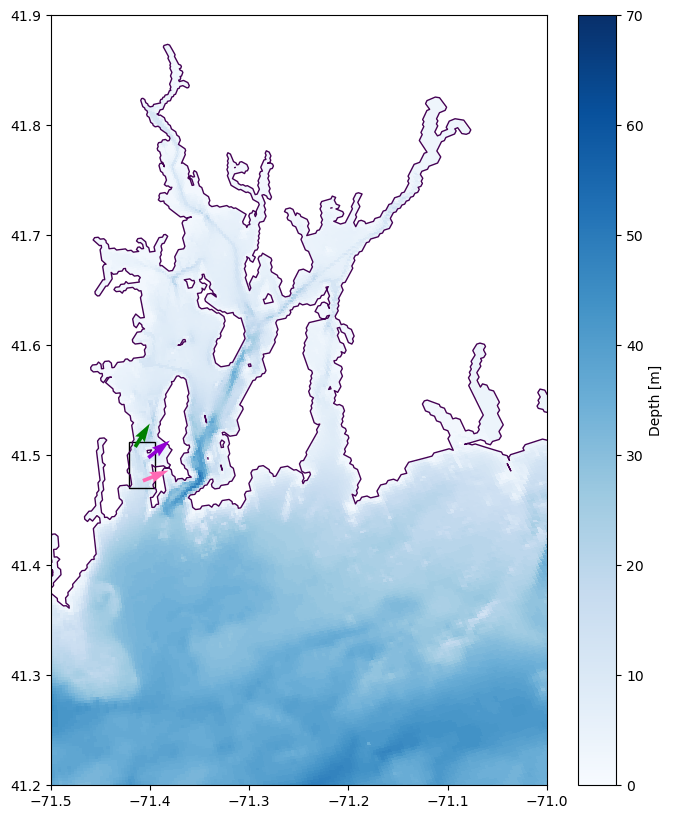

In [204]:
fig, ax = plt.subplots(figsize = [8,10])
from matplotlib.patches import Polygon

ax.contour(grid['lon_rho'], grid['lat_rho'], grid['mask_rho'], c = 'k', linewidths = 1, levels = [0])
im = ax.pcolormesh(grid['lon_rho'], grid['lat_rho'], grid['h'].where(grid['mask_rho'] > 0), cmap = 'Blues', vmin = 0, vmax = 70)
ax.plot(grid['lon_rho'].isel(eta_rho = 0), grid['lat_rho'].isel(eta_rho = 0), c = 'r', lw = 3)
cbar = plt.colorbar(im, ax = ax)
cbar.set_label('Depth [m]')


x1 = -71.42093
y1 = 41.4699
y2 = 41.512324
x2 = -71.395244

ax.set_xlim([-71.5,-71])
ax.set_ylim([41.2,41.9])

y = np.array([[x1,y1], [x1,y2], [x2,y2], [x2,y1]])

p = Polygon(y, facecolor = 'none', edgecolor = 'k')

ax.add_patch(p)

# ax.quiver(df['Lon'].values,df['Lat'].values, df['U'].values, df['V'].values)
clr = ['r', 'b', 'g', 'darkviolet', 'hotpink']
for i in df.index:
    lat = df['Lat'][i]
    lon = df['Lon'][i]
    u = df['U'][i]
    v = df['V'][i]
    col = clr[i]
    ax.quiver(lon,lat, u, v, zorder = 3, units = 'xy', color = col)

Text(0, 0.5, 'Y Distance [m]')

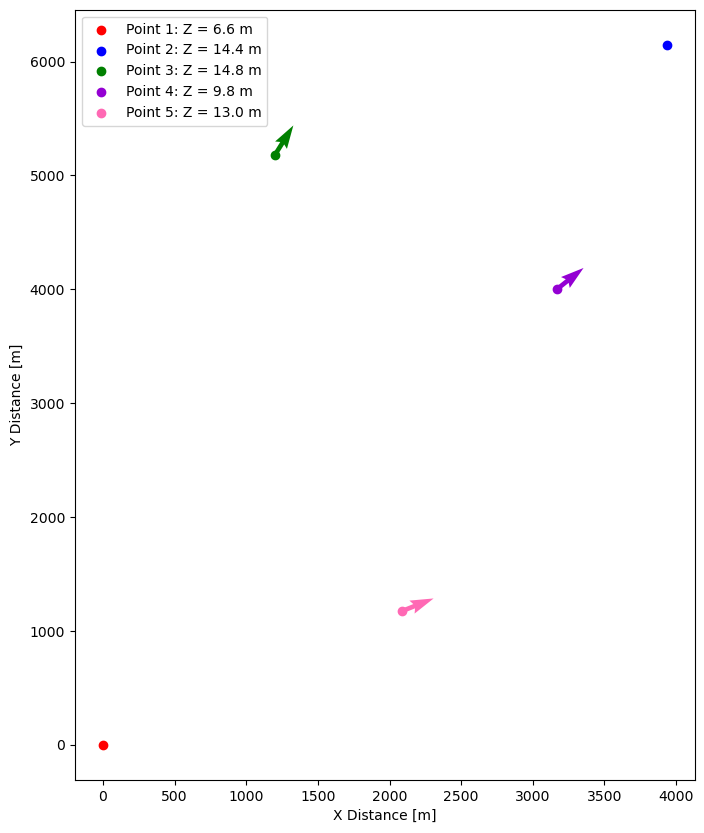

In [203]:
fig, ax = plt.subplots(figsize = [8,10])
clr = ['r', 'b', 'g', 'darkviolet', 'hotpink']
for i in df.index:
    Y = df['Y0'][i]
    X = df['X0'][i]
    u = df['U'][i]
    v = df['V'][i]
    Z = df['Z'][i]
    col = clr[i]
    ax.quiver(X,Y, u, v, zorder = 3, units = 'inches', color = col)
    ax.scatter(X,Y, color = col, label = 'Point ' + str(i+1) + ': Z = ' + str(round(float(Z),1)) + ' m')
    
ax.legend()
ax.set_xlabel('X Distance [m]')
ax.set_ylabel('Y Distance [m]')

In [201]:
round(float(Z),1)

6.6